# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## ⚙️ Import Libraries

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
import random
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import keras_cv

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

/opt/homebrew/Caskroom/miniconda/base/envs/anndl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ⏳ Load and inspect the data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

X = (X).astype('float32')

print('Before data points filter shape:', X.shape, y.shape)

import json
with open('training-data-filter/blacklist.json', 'r') as file:
	blacklist = json.load(file)
blacklist = sorted(blacklist['blacklist'])
X = np.delete(X, blacklist, axis=0)
y = np.delete(y, blacklist, axis=0)

print('After data points filter shape:', X.shape, y.shape)

train_size = int(X.shape[0] * 0.8)
val_size = int(X.shape[0] * 0.1)
test_size = X.shape[0] - train_size - val_size

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=val_size, stratify=y_train)

# Copy for later
y_train_cat = y_train

# Convert to one hoot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Before data points filter shape: (13759, 96, 96, 3) (13759, 1)
After data points filter shape: (11959, 96, 96, 3) (11959, 1)
(9567, 96, 96, 3) (1195, 96, 96, 3) (1197, 96, 96, 3) (9567, 8) (1195, 8) (1197, 8)
[0. 0. 0. 0. 0. 0. 0. 1.]
[7]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 0.]


In [3]:
# Labels
labels = {
	0: "Basophil",
	1: "Eosinophil",
	2: "Erythroblast",
	3: "Immature granulocytes",
	4: "Lymphocyte",
	5: "Monocyte",
	6: "Neutrophil",
	7: "Platelet"
}

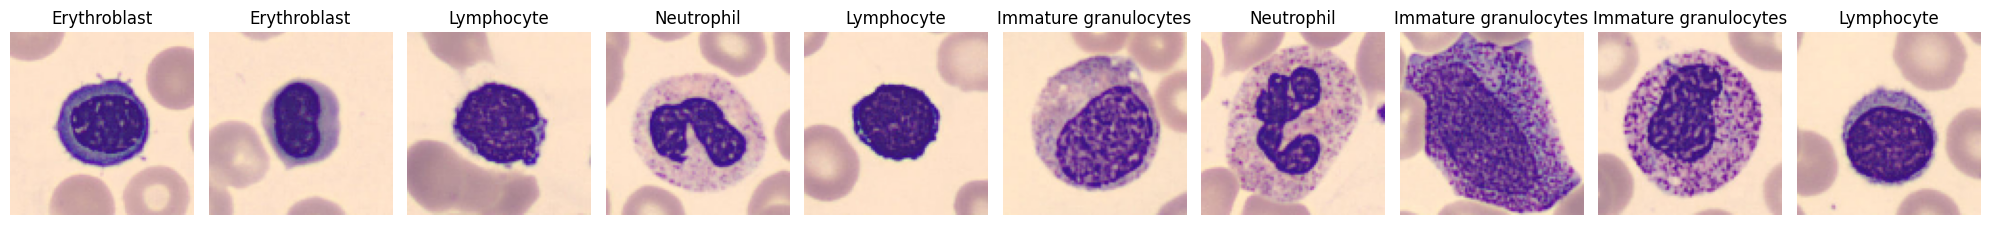

In [4]:
# Inspect data
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_val)), num_img)


def get_label(y):
    index = np.where(y == 1)[0]
    return labels[int(index)]

def plot(img, lab, indices):
    fig, axes = plt.subplots(1, len(indices), figsize=(20, 20))
    # Iterate through the selected number of images
    for i, idx in enumerate(indices):
        ax = axes[i % num_img]
        ax.imshow(np.squeeze(img[idx] / 255), vmin=0., vmax=1.)
        ax.set_title(get_label(lab[idx]))
        ax.axis('off')

    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()
plot(X_train, y_train, random_indices)

## 🛠️ Train and Save the Model

In [5]:
# Initialise imageNet model with pretrained weights, for transfer learning
efficientNetV2 = tfk.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=X_train[0].shape,
    classes=len(labels),
    pooling='avg',
    include_preprocessing=True,
    #name="efficientnetv2-l",
)

# Display a summary of the model architecture
#efficientNetV2.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(efficientNetV2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


2024-11-12 00:22:13.134586: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-12 00:22:13.134611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-12 00:22:13.134621: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-12 00:22:13.134639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-12 00:22:13.134649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Make class weights balance for fitting

In [6]:
# Flat the train labels
y_train_cat_flat = np.ravel(y_train_cat)

# Make weights proportional to class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(data['labels']), 
    y=y_train_cat_flat
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.753482404692082, 1: 0.6853151862464183, 2: 1.3777361751152073, 3: 0.7381944444444445, 4: 1.7612297496318114, 5: 1.504245283018868, 6: 0.6415638412017167, 7: 0.9101027397260274}


In [7]:
efficientNetV2.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=X_train[0].shape, name='input_layer')

# Apply data augmentation for training robustness
#augmentation = tf.keras.Sequential([
#], name='preprocessing')
#
#x = augmentation(inputs)

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = efficientNetV2(inputs)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-5), metrics=['accuracy'])

# Display a summary of the model architecture
#tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [8]:
augmix = keras_cv.layers.AugMix([0, 255])
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
def augment_fn(image, label):
    image = augmix(image)  # Apply AugMix augmentation
    return image, label

augmented_dataset = dataset.map(augment_fn)

# Batch the dataset (this creates a _BatchDataset)
#batched_dataset = augmented_dataset.batch(2)

# Visualize the first batch of augmented images
#def visualize_batch(batch):
#    images, labels = batch
#    plt.figure(figsize=(10, 10))
#    for i in range(len(images)):
#        plt.subplot(1, len(images), i + 1)
#        plt.imshow(images[i] / 255)  # Visualize the image
#        plt.axis('off')  # Turn off axes for a cleaner view
#    plt.show()

# Iterate through the dataset and visualize a batch
#for batch in batched_dataset.take(1):  # Visualize the first batch
#    visualize_batch(batch)

# Convert back to NumPy arrays
images_list = []
labels_list = []
# Iterate through the dataset and collect images and labels
for image, label in augmented_dataset:
    images_list.append(image.numpy())  # Convert image tensor to numpy array
    labels_list.append(label.numpy())  # Convert label tensor to numpy array

# Convert lists to NumPy arrays
X_numpy = np.array(images_list)  # Convert the images list to a NumPy array
y_numpy = np.array(labels_list)  # Convert the labels list to a NumPy array

# Print the shapes
print(f"X_numpy shape: {X_numpy.shape}")
print(f"y_numpy shape: {y_numpy.shape}")

X_train = X_numpy
y_train = y_numpy


2024-11-12 00:22:22.919431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-12 00:24:43.770913: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_numpy shape: (9567, 96, 96, 3)
y_numpy shape: (9567, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015624863..1.0000001].


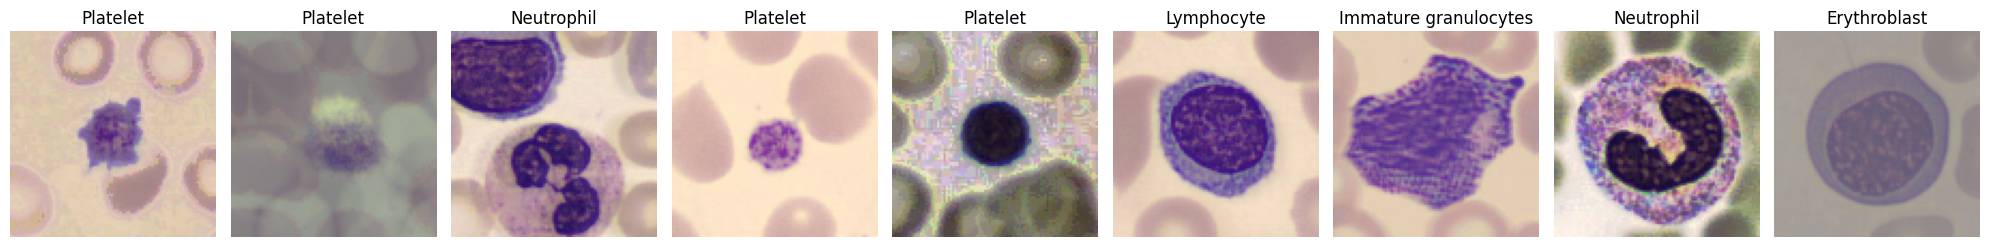

In [17]:
plot(X_train, y_train, [12, 13, 14, 16, 20, 100, 200, 300, 400])

In [ ]:

# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=512,
    epochs=800,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
from datetime import datetime
model_filename = f'EfficientNetV2L-{str(final_val_accuracy)}-{datetime.now().strftime("%y%m%d_%H%M%S")}.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
#del tl_model

Epoch 1/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 209s 9s/step - accuracy: 0.1223 - loss: 2.1768 - val_accuracy: 0.1021 - val_loss: 2.1571
Epoch 2/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.1160 - loss: 2.1720 - val_accuracy: 0.1105 - val_loss: 2.1430
Epoch 3/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.1255 - loss: 2.1524 - val_accuracy: 0.1172 - val_loss: 2.1294
Epoch 4/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.1255 - loss: 2.1492 - val_accuracy: 0.1255 - val_loss: 2.1163
Epoch 5/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.1330 - loss: 2.1398 - val_accuracy: 0.1356 - val_loss: 2.1038
Epoch 6/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.1400 - loss: 2.1289 - val_accuracy: 0.1448 - val_loss: 2.0916
Epoch 7/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.1456 - loss: 2.1202 - val_accuracy: 0.1548 - val_loss: 2.0801
Epoch 8/800
19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.1448 - loss: 2.1070 - val_accuracy: 0.1640 - 

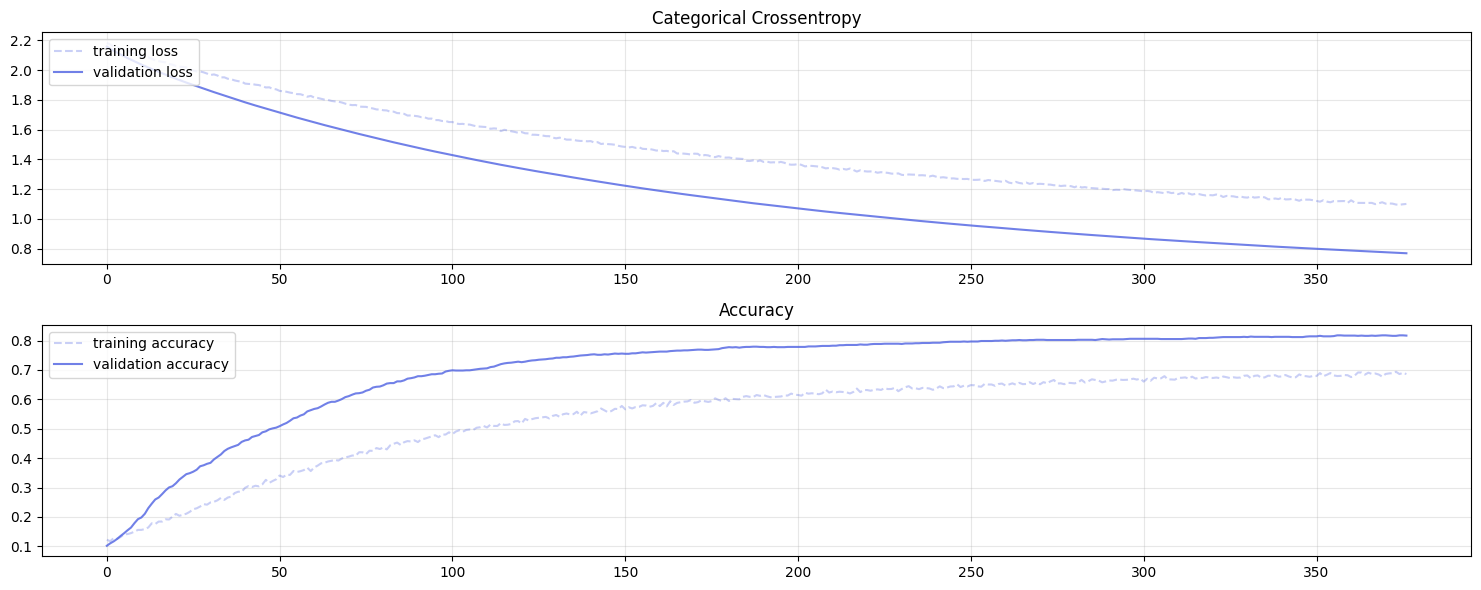

In [10]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for both re-trained and transfer learning models
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', label='training loss', linestyle='--')
ax1.plot(tl_history['val_loss'], label='validation loss', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both re-trained and transfer learning models
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', label='training accuracy', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='validation accuracy', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

## 👔 Load a trained model (if needed!)

In [11]:
#tl_model = tf.keras.models.load_model('KaggleEfficientNetV2L85.1241109_182031.keras')

## ✍🏿 Make evaluation

Predictions Shape: (1197, 8)
Accuracy score over the test set: 0.8204
Precision score over the test set: 0.8241
Recall score over the test set: 0.8204
F1 score over the test set: 0.8195


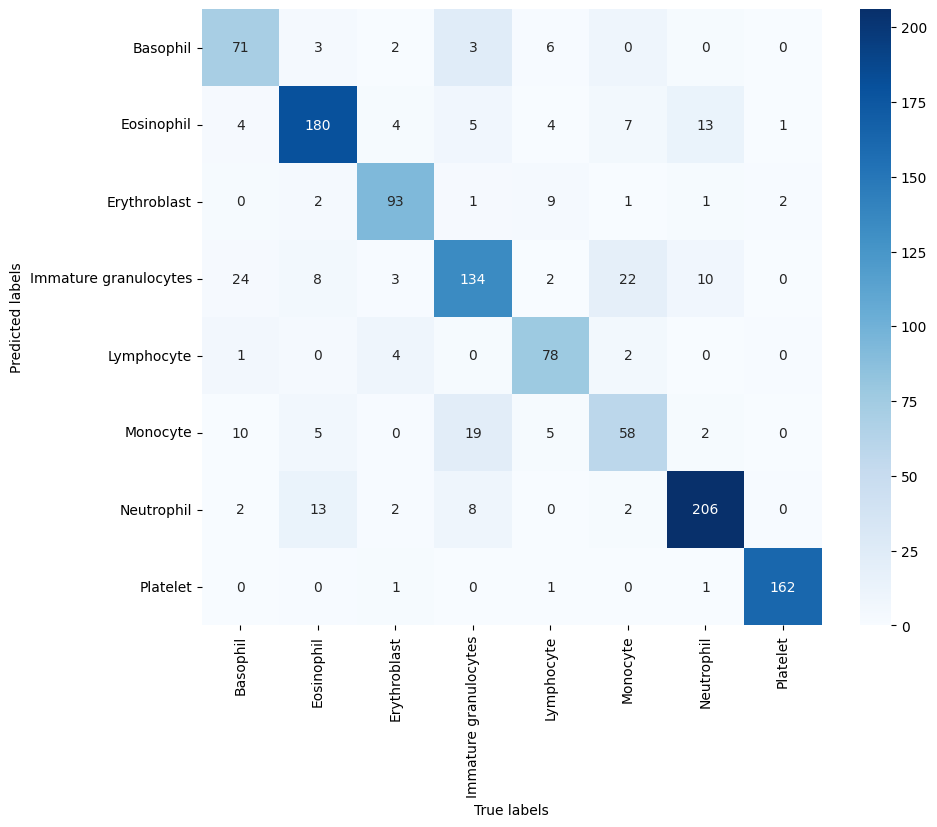

In [12]:
#loss, acc = tl_model.evaluate(X_test, y_test, verbose=2)
#print('Model, accuracy: {:5.2f}%'.format(100 * acc))

# Predict labels for the entire test set
predictions = tl_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [18]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('EfficientNetV2L-81.76-241112_080233.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [19]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py EfficientNetV2L-81.76-241112_080233.keras

  adding: model.py (deflated 54%)
  adding: EfficientNetV2L-81.76-241112_080233.keras (deflated 11%)
